<a href="https://colab.research.google.com/github/davidsjohnson/evalxai_studies/blob/main/notebooks/two4two_model_and_data_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
import os
import sys
from pathlib import Path
import tarfile
import random

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

from PIL import Image

torch.backends.cudnn.benchmark = True

In [2]:
torch.__version__

'2.4.0+cpu'

# Params

In [3]:
CLASSES = ['Healthy', 'OC Degeneration']
modeltype = 'mobilenet'
ds = 'sick_ones_bendbias'

# Setup and Load Datasets

In [4]:
# data downloading and dataset utilities

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)

    return Path(file_path)

def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)
  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['ill'])

        if self.transform:
            image = self.transform(image)

        return image, label

## Load Dataset and Dataloaders


In [5]:
# download data direcly from sciebo
# (or setup own data location if prefered)

data_dir = download_file(url="https://uni-bielefeld.sciebo.de/s/AIJLvXMwP0ngEiW/download",
                         file_name="two4two_datasets.tar.gz",
                         cache_dir='/content/data', # change this if not using Colab
                         extract=True,
                         force_download=False,
                         archive_folder='two4two_datasets')
data_dir

File already exists at: /content/data\two4two_datasets.tar.gz
File extracted to: /content/data


WindowsPath('/content/data/two4two_datasets')

In [6]:
ds_dir = data_dir / ds
ds_dir

WindowsPath('/content/data/two4two_datasets/sick_ones_bendbias')

In [7]:
# load datasets and dataloaders for pytorch processing
transform = transforms.Compose([
    transforms.ToTensor(),
])


train_df = load_dataframe(ds_dir, 'train')
val_df = load_dataframe(ds_dir, 'validation')
test_df = load_dataframe(ds_dir, 'test')

train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                              num_workers=6, pin_memory=True)

val_dataset = ImageDataset(val_df,  ds_dir / 'validation', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                            num_workers=6, pin_memory=True)

test_dataset = ImageDataset(test_df,  ds_dir / 'test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                             num_workers=6, pin_memory=True)

# Model Loading and Evaluation





In [8]:
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):
  """Loads a MobileNetV2 model, optionally loading from a checkpoint.

  Args:
    num_classes: The number of output classes.
    pretrained: Whether to load the pre-trained weights.
    checkpoint_path: Path to a checkpoint file to load.

  Returns:
    A MobileNetV2 model.
  """
  model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
  model.classifier[1] = nn.Linear(model.last_channel, num_classes)

  if checkpoint_path:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    print(f"Loaded checkpoint from: {checkpoint_path}")

  return model

In [9]:
def set_seed(seed):
  """
  Sets random seeds for reproducibility.
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


In [10]:
checkpoint_path = download_file(url='https://uni-bielefeld.sciebo.de/s/5uQFFsAprXT05in/download',
                                file_name='best_model.pth',
                                cache_dir='/content/model/mobilenetv2_checkpoint', # change this if not using Colab
                                extract=False,
                                force_download=False)
checkpoint_path

File already exists at: /content/model/mobilenetv2_checkpoint\best_model.pth


WindowsPath('/content/model/mobilenetv2_checkpoint/best_model.pth')

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Evaluate Model

In [15]:
# load best model and evaluate
model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=False,
                         checkpoint_path=checkpoint_path)
model.to(device)

evaluate_model(model, train_dataloader, criterion, device)
evaluate_model(model, val_dataloader, criterion, device)
evaluate_model(model, test_dataloader, criterion, device)

<ipython-input-8-8ca1eb820737>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint from: /content/model/mobilenetv2_checkpoint/best_model.pth
Evaluation Loss: 0.2447, Evaluation Accuracy: 0.8924
Evaluation Loss: 0.2928, Evaluation Accuracy: 0.8710
Evaluation Loss: 0.2911, Evaluation Accuracy: 0.8680


(0.2910529184848704, 0.868)

In [12]:
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):

    model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)

    if checkpoint_path:
        # Load the checkpoint for CPU usage
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint)
        print(f"Loaded checkpoint from: {checkpoint_path}")

    return model

model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=False,
                         checkpoint_path=checkpoint_path)
model.to(device)



Loaded checkpoint from: \content\model\mobilenetv2_checkpoint\best_model.pth


C:\Users\hp 840\AppData\Local\Temp\ipykernel_18164\2051365035.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [15]:
import torch
from model import Model
from explainers import saliency_explainer, intgrad_explainer
from agg_explainers import AGGmean_explainer
from utils import prepare_input
from plot import plot_explanations
from torchvision import transforms
from utils import prepare_input

from pathlib import Path
from torchvision.models import resnet50, ResNet50_Weights

# Localiser dynamiquement une image
image_path = next(extracted_dir.rglob("*.png"))  # Récupère le premier fichier PNG trouvé
print(f"Image path: {image_path}")


_, prepared_input = prepare_input(str(image_path))
prepared_input = prepared_input.float()

transforms = ResNet50_Weights.IMAGENET1K_V1.transforms()

extracted_dir = Path(data_dir) / "two4two_datasets"


original_image, prepared_input = prepare_input(image_path, transforms=transforms, grayscale=False)
prepared_input = prepared_input.to(device)
prepared_input.requires_grad = True

Image path: \content\data\two4two_datasets\two4two_datasets\sick_ones_bendbias\test\000773b6-93f9-4a21-bbd5-7e4af0c31f74.png


In [ ]:

from agg_explainers import AGGmean_explainer
from explainers import intgrad_explainer, guidedbackprop_explainer


wrapped_model = Model(model=pytorch_model, device="cuda" if torch.cuda.is_available() else "cpu")
# from explainers import saliency_explainer

# explainer = saliency_explainer(model=wrapped_model)
# explanation = explainer.explain(prepared_input, target=1)  # Classe cible = 1
# print(explanation)

# # Initialiser plusieurs explainers
# explainer1 = saliency_explainer(model=wrapped_model)
# explainer2 = intgrad_explainer(model=wrapped_model)
# explainer3 = guidedbackprop_explainer(model=wrapped_model)

# # Combinaison via AGGmean
# agg_explainer = AGGmean_explainer(
#     model=wrapped_model,
#     explainers=[explainer1, explainer2, explainer3],
#     explainers_kwargs=[{}, {}, {}],
# )

# explanation_combined = agg_explainer.explain(prepared_input, target=1)
# print(explanation_combined)





In [16]:
from explainers import (
    saliency_explainer,
    intgrad_explainer,
    smoothgrad_explainer,
    vargrad_explainer,
    guidedbackprop_explainer
)
from agg_explainers import AGGopt_explainer

pytorch_model = load_mobilenetv2(num_classes=2, pretrained=False)  
wrapped_model = Model(model=pytorch_model, device=device)

# Initialisation des explainers
saliency = saliency_explainer(wrapped_model)
intgrad = intgrad_explainer(wrapped_model)
smoothgrad = smoothgrad_explainer(wrapped_model)
vargrad = vargrad_explainer(wrapped_model)
guidedbp = guidedbackprop_explainer(wrapped_model)

saliency_kwargs = {"abs": True}
intgrad_kwargs = {"baselines": torch.zeros_like(prepared_input)}
smoothgrad_kwargs = {}
vargrad_kwargs = {}

# Liste des explainers et leurs arguments
explainers = [saliency, intgrad, smoothgrad, vargrad]
explainers_kwargs = [saliency_kwargs, intgrad_kwargs, smoothgrad_kwargs, vargrad_kwargs]

agg_opt = AGGopt_explainer(wrapped_model, explainers, explainers_kwargs, baseline=None, segments=None)


In [17]:
target_class = 1
explanation_saliency = saliency.explain(prepared_input, target=target_class)
print(f"Saliency Explanation keys: {explanation_saliency.keys()}")

explanation_intgrad = intgrad.explain(prepared_input, target=target_class)
print(f"Integrated Gradients Explanation keys: {explanation_intgrad.keys()}")

explanation_smoothgrad = smoothgrad.explain(prepared_input, target=target_class)
print(f"SmoothGrad Explanation keys: {explanation_smoothgrad.keys()}")

explanation_vargrad = vargrad.explain(prepared_input, target=target_class)
print(f"VarGrad Explanation keys: {explanation_vargrad.keys()}")


explanation_aggopt = agg_opt.explain(prepared_input, target=target_class)
print(f"AGGopt Explanation keys: {explanation_aggopt.keys()}")

Saliency Explanation keys: dict_keys(['saliency'])
Integrated Gradients Explanation keys: dict_keys(['IntGrad'])
SmoothGrad Explanation keys: dict_keys(['SmoothGrad'])
VarGrad Explanation keys: dict_keys(['VarGrad'])


c:\Users\hp 840\Downloads\main - Copie\main\src\base_explainer.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target_idx).to(dtype=torch.long).to(self.model.torch_device)


AGGopt Explanation keys: dict_keys(['AGGopt'])


In [20]:
def normalize_explanation(explanation):
    explanation -= explanation.min()
    explanation /= explanation.max()
    return explanation

# Réduction et normalisation des explications

print(explanation_aggopt)
saliency_map = normalize_explanation(explanation_saliency["saliency"])
intgrad_map = normalize_explanation(explanation_intgrad["IntGrad"])
smoothgrad_map = normalize_explanation(explanation_smoothgrad["SmoothGrad"])
vargrad_map = normalize_explanation(explanation_vargrad["VarGrad"])
aggopt_map = normalize_explanation(explanation_aggopt["AGGopt"])


{'AGGopt': array([[0.03589931, 0.04173119, 0.04576211, ..., 0.00799971, 0.00616575,
        0.00554608],
       [0.04666933, 0.05122201, 0.05649351, ..., 0.01058961, 0.00756403,
        0.00580475],
       [0.06036882, 0.06558559, 0.07314766, ..., 0.01405399, 0.00885015,
        0.00572484],
       ...,
       [0.00719613, 0.00874194, 0.01200152, ..., 0.00850792, 0.0052227 ,
        0.00240192],
       [0.00624069, 0.00720972, 0.00861919, ..., 0.00451904, 0.00256194,
        0.00107411],
       [0.00705969, 0.00709245, 0.00680695, ..., 0.00176525, 0.0004789 ,
        0.        ]])}


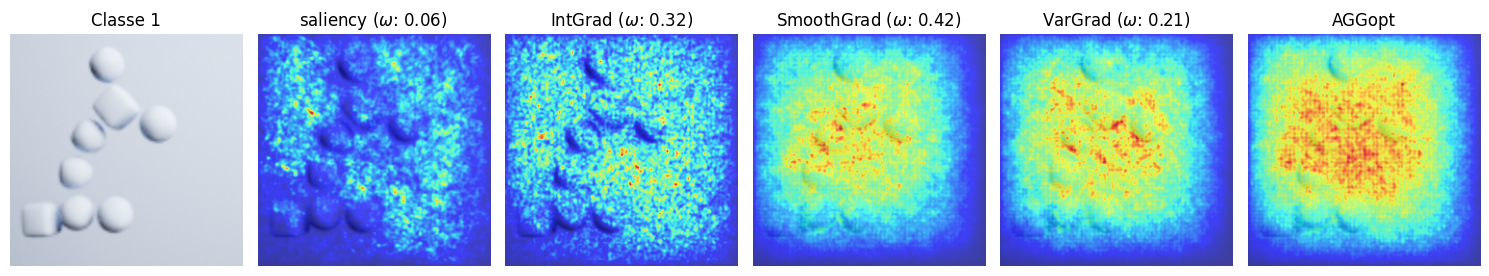

In [22]:
from plot import plot_explanations, plot_agg_explanations

# plot_explanations(
#     inputs=prepared_input.detach(),
#     explanations={
#         "Saliency": saliency_map,
#         "Integrated Gradients": intgrad_map,
#         "SmoothGrad": smoothgrad_map,
#         "VarGrad": vargrad_map,
#         "AGGopt": aggopt_map,
#     },
#     label=f"Classe {target_class}"
# )


plot_agg_explanations(prepared_input.detach(), agg_opt.explanations, label="Classe 1", overlay=True, weights=agg_opt.get_weights(), figsize=(15, 10))


In [23]:
import numpy as np

def compute_sensitivity_metrics(explainer, input_image, epsilon=0.1, num_samples=100):
    perturbations = np.random.uniform(-epsilon, epsilon, size=(num_samples,) + input_image.shape)
    explanations = [explainer.explain(input_image + perturb, target=1)["saliency"] for perturb in perturbations]
    
    # Compute SENSMAX
    max_sensitivity = max(
        np.linalg.norm(explanations[i] - explanations[j]) 
        for i in range(len(explanations)) for j in range(i+1, len(explanations))
    )
    
    # Compute SENSAVG
    avg_sensitivity = np.mean(
        [np.linalg.norm(explanations[i] - explanations[j]) 
         for i in range(len(explanations)) for j in range(i+1, len(explanations))]
    )
    
    return max_sensitivity, avg_sensitivity


In [24]:
from scipy.stats import pearsonr
import numpy as np

def compute_faithfulness_metrics(explainer, model, input_image, baseline_image, mask_fraction=0.2, num_samples=100):
    explanations = explainer.explain(input_image, target=1)["saliency"]
    height, width = input_image.shape[-2:]
    
    infidelity_scores = []
    correlations = []

    for _ in range(num_samples):
        # Generate a random binary mask
        mask = np.random.choice([0, 1], size=(height, width), p=[1-mask_fraction, mask_fraction])
        perturbed_image = np.where(mask == 1, baseline_image, input_image)
        
        # Compute prediction difference
        pred_diff = model.predict(input_image) - model.predict(perturbed_image)
        
        # Compute infidelity
        masked_explanation = np.sum(mask * explanations)
        infidelity_scores.append((masked_explanation - pred_diff) ** 2)
        
        # Compute correlation
        correlations.append(pearsonr(mask.flatten() * explanations.flatten(), pred_diff.flatten())[0])

    infidelity = np.mean(infidelity_scores)
    faithfulness_corr = np.mean(correlations)

    return infidelity, faithfulness_corr


In [25]:
import numpy as np

def evaluate_robustness(explainer, input_image, epsilon=0.1, num_samples=100):
    """
    Evaluate Robustness Metrics (SENSMAX and SENSAVG).

    Args:
        explainer: The explainer object (e.g., saliency_explainer).
        input_image: The original image as a numpy array or tensor.
        epsilon: The range of perturbations.
        num_samples: Number of perturbation samples.

    Returns:
        sensmax: Maximum sensitivity value.
        sensavg: Average sensitivity value.
    """
    perturbations = np.random.uniform(-epsilon, epsilon, size=(num_samples,) + input_image.shape)
    original_explanation = explainer.explain(input_image, target=1)["saliency"]

    explanations = [
        explainer.explain(input_image + perturb, target=1)["saliency"] for perturb in perturbations
    ]

    # Compute sensitivity metrics
    max_sensitivity = max(
        np.linalg.norm(original_explanation - perturbed_explanation)
        for perturbed_explanation in explanations
    )
    avg_sensitivity = np.mean(
        [np.linalg.norm(original_explanation - perturbed_explanation) for perturbed_explanation in explanations]
    )

    return max_sensitivity, avg_sensitivity


In [ ]:
def evaluate_robustness(explainer, input_image, epsilon=0.1, num_samples=100):
    """
    Evaluate Robustness Metrics (SENSMAX and SENSAVG).

    Args:
        explainer: Explainer object with an `explain` method.
        input_image: Input image as a numpy array.
        epsilon: Magnitude of perturbation.
        num_samples: Number of random perturbations.

    Returns:
        sensmax: Maximum sensitivity value.
        sensavg: Average sensitivity value.
    """
    # Generate perturbations
    perturbations = np.random.uniform(-epsilon, epsilon, size=(num_samples,) + input_image.shape)
    
    # Compute the original explanation
    original_explanation = explainer.explain(torch.tensor(input_image).float(), target=1)["saliency"]

    # Compute explanations for perturbed inputs
    explanations = [
        explainer.explain(torch.tensor(input_image + perturb).float(), target=1)["saliency"]
        for perturb in perturbations
    ]
    
    # Compute sensitivity metrics
    diffs = [np.linalg.norm(original_explanation - explanation) for explanation in explanations]
    sensmax = max(diffs)
    sensavg = np.mean(diffs)
    
    return sensmax, sensavg


In [29]:
# Initialize the explainer
saliency_explainer_instance = saliency_explainer(model=wrapped_model)

# Evaluate robustness
sensmax, sensavg = evaluate_robustness(
    saliency_explainer_instance,  # Pass the explainer object
    prepared_input.detach().numpy(),
    epsilon=0.1,
    num_samples=100
)
print(f"Max-Sensitivity: {sensmax}, Average-Sensitivity: {sensavg}")



c:\Users\hp 840\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Max-Sensitivity: 17.95538330078125, Average-Sensitivity: 14.462249755859375
